In [178]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt
import time

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/helpers"))

In [179]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [180]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.9
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 5400
Test set size: 600


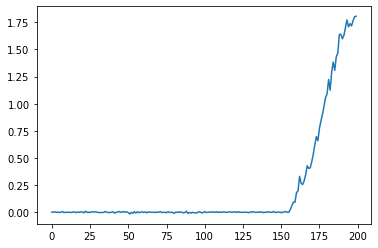

In [226]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
#     t_x_data[i] = np.sin(0.1*i) + 0.1*np.random.randn() #train_RO_se3s[i][0,3]
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]
    
plt.plot(t_x_data[0:200])

In [227]:
dim1_data = t_x_data
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()

In [228]:
from data_preparation import sliding_window_delta

training_data = dim1_data_scaled.reshape(-1,1)

seq_length = 10
single_output_length = 1
x, y = sliding_window_delta(training_data, seq_length)

train_val_ratio = 0.8
train_size = int(len(y) * train_val_ratio)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

valX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
valY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("dataX:",dataX.shape)
print("trainX:",trainX.shape)
print("valX:",valX.shape)
print("dataY:",dataY.shape)
print("trainY:",trainY.shape)
print("valY:",valY.shape)

dataX: torch.Size([5390, 10, 1])
trainX: torch.Size([4312, 10, 1])
valX: torch.Size([1078, 10, 1])
dataY: torch.Size([5390, 1])
trainY: torch.Size([4312, 1])
valY: torch.Size([1078, 1])


In [229]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_dim, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        # hidden and cell states
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [ ]:
torch.manual_seed(0)

num_epochs = 151
learning_rate = 0.01

input_size = 1
hidden_size = 30
num_layers = 1

model = LSTM(input_size, single_output_length, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
# for epoch in range(num_epochs):
#     outputs = model(trainX)#.reshape(-1,single_output_length)
#     optimizer.zero_grad()
    
#     # obtain the loss function
#     loss = criterion(outputs, trainY)
    
#     loss.backward()
    
#     optimizer.step()
#     if epoch % 50 == 0:
#         print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


In [306]:
# from this post
# https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e
from torch.utils.data.dataset import random_split

# dataset = TensorDataset(dataX, dataY) # dataset = CustomDataset(x_tensor, y_tensor)

# train_dataset, val_dataset = random_split(dataset, [80, 20])

train_dataset = TensorDataset(trainX,trainY)
val_dataset = TensorDataset(valX,valY)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size*2)

def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

# Estimate a and b
torch.manual_seed(0)

model = LSTM(input_size, single_output_length, hidden_size, num_layers)
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_step = make_train_step(model, loss_fn, optimizer)

n_epochs = 5
training_losses = []
validation_losses = []

for epoch in range(n_epochs):
    batch_losses = []
    for x_batch, y_batch in train_loader:
        loss = train_step(x_batch, y_batch)
        batch_losses.append(loss)
    training_loss = np.mean(batch_losses)
    training_losses.append(training_loss)

    with torch.no_grad():
        val_losses = []
        model.eval()
        for x_val, y_val in val_loader:
            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat).item()
            val_losses.append(val_loss)
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)

    print(f"[{epoch+1}] Training loss: {training_loss:.5f}\t Validation loss: {validation_loss:.5f}")

[1] Training loss: 0.00839	 Validation loss: 0.00496
[2] Training loss: 0.00779	 Validation loss: 0.00504
[3] Training loss: 0.00786	 Validation loss: 0.00498
[4] Training loss: 0.00781	 Validation loss: 0.00501
[5] Training loss: 0.00780	 Validation loss: 0.00498


In [308]:
from torch.utils.data.dataset import TensorDataset
torch.manual_seed(0)

train_ds = TensorDataset(trainX,trainY)
valid_ds = TensorDataset(valX,valY)

from network_helpers import *

def loss_batch_tmp(model,loss_func,xb,yb,opt=None):    
    loss=loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(),len(xb)

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch_tmp(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch_tmp(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

batch_size = 100
epochs = 5
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = LSTM(input_size, single_output_length, hidden_size, num_layers)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

t0 = time.time()
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, optimizer, train_dl, valid_dl)
t1 = time.time()
total_time = t1-t0
print("Time elapsed:",total_time,"s")

0 0.005364970663685096
1 0.005329918757263322
2 0.005299060396177968
3 0.005090807463044166
4 0.004239940765514237
Time elapsed: 2.1197807788848877 s


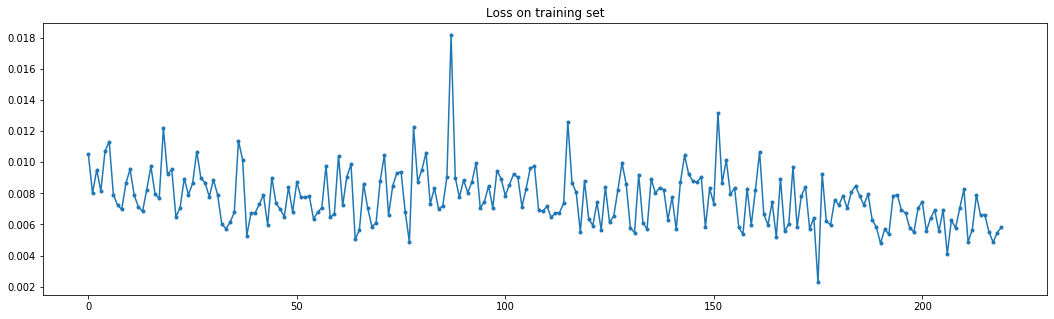

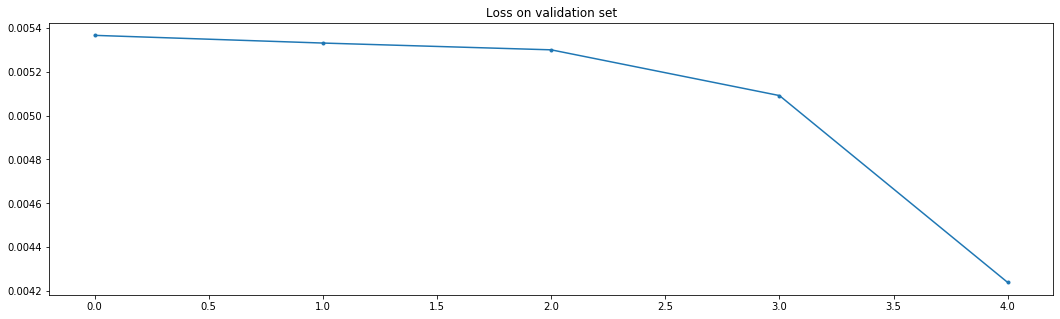

In [309]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

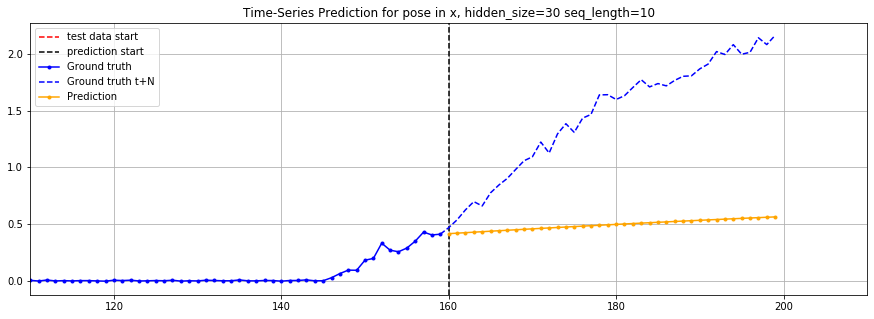

In [302]:
from prediction import appender, get_predictions_out_to_horizon
prediction_start_index = 160 #int(len(dataY)*train_test_ratio) #160
horizon = 40
model.eval()
input_seq = dataX[prediction_start_index]
future_val = model(dataX[[prediction_start_index]]).data.numpy()[0][0] + dataX[prediction_start_index][-1].data.numpy()
predictions = get_predictions_out_to_horizon(model,horizon,input_seq,future_val)

# Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
data_predict_rescaled = predictions*dim1_data.std()+dim1_data.mean()
gt_vals_rescaled = (dataX.data.numpy()[:,-1]+dataY.data.numpy())*dim1_data.std()+dim1_data.mean()

x_axis_ticks_horizon = np.linspace(prediction_start_index,prediction_start_index+horizon-1,horizon)
x_axis_ticks_tm1 = np.linspace(prediction_start_index-1,prediction_start_index+horizon-1,horizon+1)

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
view_size = horizon+10
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(gt_vals_rescaled[:prediction_start_index,0],'b.-',label="Ground truth")
plt.plot(x_axis_ticks_tm1,gt_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon,0],'b--',label="Ground truth t+N")
plt.plot(x_axis_ticks_horizon,data_predict_rescaled,'.-',color="orange",label="Prediction")

title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

In [253]:
import datetime
from time import strftime

from metrics import get_error_metrics

save_plots = True
prediction_start_index = 140 #int(len(dataY)*train_test_ratio) - 50
horizon = 40 -1 # -1 because we do first step outside the loop
num_frames_to_render = 50
all_short_rmse = []
all_med_rmse = []
all_long_rmse = []

experiment_dir = '/workspace/data/pose-prediction-odometry/'+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
if save_plots:
    print(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
#     os.mkdir(experiment_dir)
    for frame in range(prediction_start_index,prediction_start_index+num_frames_to_render):
        prediction_start_index = frame
        model.eval()
        input_seq = dataX[prediction_start_index]
        future_val = model(dataX[[prediction_start_index]]).data.numpy()[0][0] + dataX[prediction_start_index][-1].data.numpy()
        predictions = get_predictions_out_to_horizon(model,horizon,input_seq,future_val)

        # Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
        data_predict_rescaled = predictions*dim1_data.std()+dim1_data.mean()
        gt_vals_rescaled = (dataX.data.numpy()[:,-1]+dataY.data.numpy())*dim1_data.std()+dim1_data.mean()

        # Error metrics
        gt_predictions = gt_vals_rescaled[prediction_start_index:prediction_start_index+horizon,0]
        model_predictions = data_predict_rescaled
        short_rmse, med_rmse, long_rmse = get_error_metrics(gt_predictions,model_predictions)
        all_short_rmse.append(short_rmse)
        all_med_rmse.append(med_rmse)
        all_long_rmse.append(long_rmse)
        
#         x_axis_ticks_horizon = np.linspace(prediction_start_index,prediction_start_index+horizon-1,horizon)
#         x_axis_ticks_tm1 = np.linspace(prediction_start_index-1,prediction_start_index+horizon-1,horizon+1)

#         fig = plt.figure(figsize=(15,5))
#         plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
#         plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
#         view_size = horizon+10
#         x_centre = prediction_start_index #len(dataY)*train_test_ratio
#         plt.xlim(x_centre-view_size,x_centre+view_size)
#         plt.plot(gt_vals_rescaled[:prediction_start_index,0],'b.-',label="Ground truth")
#         plt.plot(x_axis_ticks_tm1,gt_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon,0],'b--',label="Ground truth t+N")
#         plt.plot(x_axis_ticks_horizon,data_predict_rescaled,'.-',color="orange",label="Prediction")

#         title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
#                      +' seq_length='+str(seq_length)
#         plt.title(title_string)
#         plt.grid()
#         plt.legend()
#         plt.savefig("%s%s%i%s%i%s" % (experiment_dir,'/hiddensize-',hidden_size,'-frame-',frame,'.png'), \
#                 bbox_inches='tight')
#         plt.close(fig)
    print("Mean short RMSE:",np.array(all_short_rmse).mean())
    print("Mean med RMSE:",np.array(all_med_rmse).mean())
    print("Mean long RMSE:",np.array(all_long_rmse).mean())


10-06-2020-13-30-20
Mean short RMSE: 0.06497363940622412
Mean med RMSE: 0.17903866357817397
Mean long RMSE: 0.42891902166402973


In [ ]:
# trainset = TensorDataset(trainX,trainY)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=20,
#                                           shuffle=True, num_workers=2)
# model = LSTM(input_size, single_output_length, hidden_size, num_layers)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 20 == 19:    # print every 20 mini-batches
#             print('[Epoch %d, minibatch %5d] loss: %.5f' %
#                   (epoch + 1, i + 1, running_loss / 20))
#             running_loss = 0.0

# print('Finished Training')